In [30]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2022-02-07 20:17:28--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2022-02-07 20:17:29--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  24.6MB/s    in 2m 16s  

2022-02-07 20:19:45 (24.7 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [31]:
!git clone https://github.com/niazwazir/SRCNN-Keras.git

fatal: destination path 'SRCNN-Keras' already exists and is not an empty directory.


In [32]:
cd SRCNN-Keras/

/content/SRCNN-Keras


In [33]:
!ls

baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
Image_Super_Resolution.ipynb
MOUNT_SRCNN_37_PSNR.ipynb
prepare_data.py
project.gif
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
subpixel.py
text
woman_GT.bmp
yang91


In [34]:
!unzip yang91.zip

unzip:  cannot find or open yang91.zip, yang91.zip.zip or yang91.zip.ZIP.


In [35]:
!ls

baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
Image_Super_Resolution.ipynb
MOUNT_SRCNN_37_PSNR.ipynb
prepare_data.py
project.gif
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
subpixel.py
text
woman_GT.bmp
yang91


In [36]:
!rm -r *.zip

rm: cannot remove '*.zip': No such file or directory


In [37]:
!ls

baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
Image_Super_Resolution.ipynb
MOUNT_SRCNN_37_PSNR.ipynb
prepare_data.py
project.gif
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
subpixel.py
text
woman_GT.bmp
yang91


In [38]:
cd ..

/content


In [39]:
!ls

best_model_improved.h5	DIV2K_train_HR.zip  sample_data  SRCNN-Keras


In [40]:
############### IF YOU DON'T WANT TO TRAIN :
############### Load my github model and use the output patch prediction and merging code from this same notebook lateron

In [41]:
DATADIR = "SRCNN-Keras/yang91"
DATADIR2 = "SRCNN-Keras/yang91"
#DATADIR2 = "DIV2K_train_HR"


In [43]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [44]:
scale = 2
req_size = 20
inp_size = int(req_size/scale)
stride = 15

X=[]
labels=[]

for filera in os.listdir(DATADIR):
  readpath = os.path.join(DATADIR,filera)
  img = cv2.imread(readpath)
  img = np.asarray(img)
  shapes = img.shape
  for i in range(0, shapes[0]-req_size+1, stride):
    for j in range(0, shapes[1]-req_size+1,stride):
      subimage_HR = img[i:i+req_size, j:j+req_size]
      #cv2_imshow(subimage_HR)
      subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
      X.append(subimage_LR)
      labels.append(subimage_HR)

counta=0
for filera in os.listdir(DATADIR2):
  counta=counta+1
  if(counta==300):
    break
  readpath = os.path.join(DATADIR2,filera)
  img = cv2.imread(readpath)
  img = np.asarray(img)
  shapes = img.shape
  for i in range(0, shapes[0]-req_size+1, stride):
    for j in range(0, shapes[1]-req_size+1,stride):
      subimage_HR = img[i:i+req_size, j:j+req_size]
      #cv2_imshow(subimage_HR)
      subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
      X.append(subimage_LR)
      labels.append(subimage_HR)

In [45]:
X = np.asarray(X)
labels = np.asarray(labels)
print(labels.shape)
print(X.shape)

(37698, 20, 20, 3)
(37698, 10, 10, 3)


In [46]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input,Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

In [47]:
alpha = 0.85
def basic_mse(y_true, y_pred):
  pred = tf.image.sobel_edges(y_pred)
  true = tf.image.sobel_edges(y_true)
  lossmse = tf.reduce_mean(tf.square(y_pred-y_true))
  lossedge = tf.reduce_mean(tf.square(pred-true))
  return alpha*lossmse + (1-alpha)*lossedge

In [48]:
d=64
s=12
m=3

In [49]:
d=64
s=12
m=3

inputlayer = tf.keras.layers.Input(shape=(None,None,3))
x = Conv2D(filters=d, strides=(1,1), kernel_size=7 ,padding="same")(inputlayer)
x = LeakyReLU(alpha=0.2)(x)

#the layer to reduce feature maps from d to s
x = Conv2D(filters=s, kernel_size=(1, 1),padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)

#the middle m layers
for i in range(m):
  x = Conv2D(filters=s,kernel_size=(3, 3),padding="same")(x)
  x = LeakyReLU(alpha=0.1)(x)

x = Conv2D(filters=d, kernel_size=(1, 1), padding="same")(x)
x = LeakyReLU(alpha=0.1)(x)


#final expanding layer of the model 3 channels for RGB
y = Conv2DTranspose(filters=3, kernel_size = (9,9), strides = (scale,scale), padding="same",activation=None)(x)

model = Model(inputs=inputlayer , outputs = y)

In [50]:
from keras.callbacks import ModelCheckpoint
#from keras.optimizers import Adam, SGD

In [51]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 64)    9472      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, None, None, 64)    0         
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 12)    780       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, None, None, 12)    0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 12)    1308      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, None, None, 12)    0   

In [52]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

In [53]:
history = model.fit(X,labels,batch_size=32,shuffle=True,validation_split=0.01 ,epochs=5,callbacks=[checkpoint],
                    verbose=1 )

Epoch 1/5
1167/1167 [==============================] - 13s 11ms/step - loss: 614.1946 - accuracy: 0.8483 - val_loss: 172.0715 - val_accuracy: 0.8417
Epoch 2/5
1167/1167 [==============================] - 11s 10ms/step - loss: 152.2859 - accuracy: 0.9175 - val_loss: 119.3760 - val_accuracy: 0.8371
Epoch 3/5
1167/1167 [==============================] - 9s 8ms/step - loss: 121.4547 - accuracy: 0.9272 - val_loss: 101.6424 - val_accuracy: 0.8569
Epoch 4/5
1167/1167 [==============================] - 15s 13ms/step - loss: 114.8364 - accuracy: 0.9307 - val_loss: 93.4367 - val_accuracy: 0.9061
Epoch 5/5
1167/1167 [==============================] - 11s 9ms/step - loss: 102.0743 - accuracy: 0.9383 - val_loss: 89.9361 - val_accuracy: 0.8701


In [54]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curves')

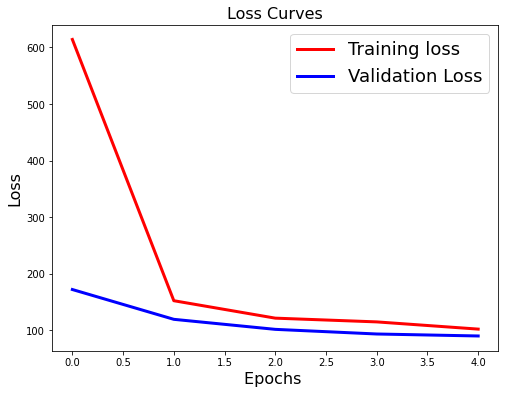

In [55]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

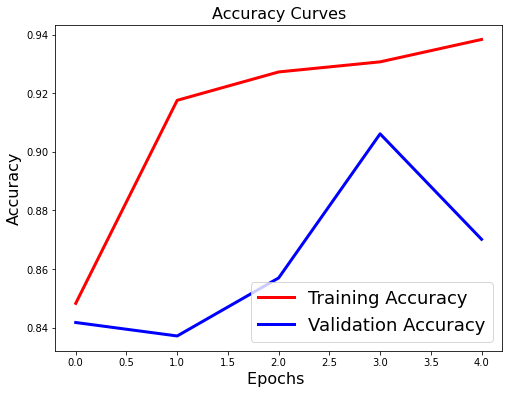

In [56]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [57]:
!ls

best_model_improved.h5	DIV2K_train_HR.zip  sample_data  SRCNN-Keras


In [58]:
from keras.models import load_model

In [59]:
#model = load_model('best_model_improved.h5')

In [60]:
def psnr_calc():
  testimg = []
  #GT = cv2.imread("/content/drive/My Drive/dataset/suparesthing/test/set5/butterfly.png")
  GT = cv2.imread("SRCNN-Keras/baby_x2_GT.png")
  GT = np.asarray(GT)
  h = GT.shape[0]
  l = GT.shape[1]
  #print(GT.shape)
  img1 = cv2.resize(GT,(int(l/2),int(h/2)),interpolation = cv2.INTER_CUBIC)
  img1 = np.asarray(img1)
  testimg.append(img1)
  testimg = np.asarray(testimg)
  print(testimg.shape)
  fin =(model.predict(testimg)[0])
  inp = cv2.resize(img1,(l,h),interpolation = cv2.INTER_CUBIC)
  GT = GT[0:fin.shape[0],0:fin.shape[1],:]
  #mse = np.square(np.subtract(GT,inp)).mean()
  mse = np.square(np.subtract(GT, fin)).mean()
  cv2_imshow(inp)
  cv2_imshow(fin)
  cv2_imshow(GT)
  import math
  psnr = 20*math.log(255.0,10) - 10*(math.log(mse,10))
  return psnr

(1, 256, 256, 3)


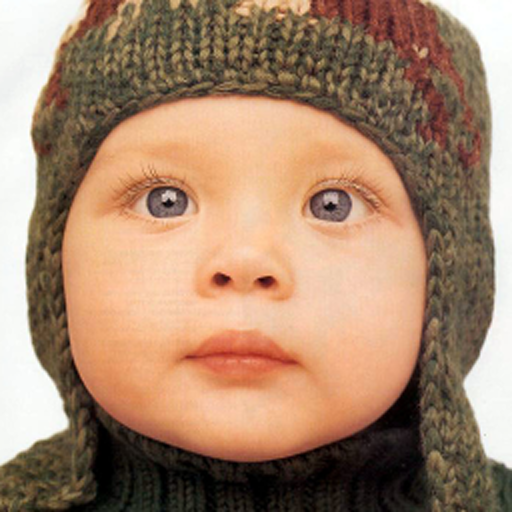

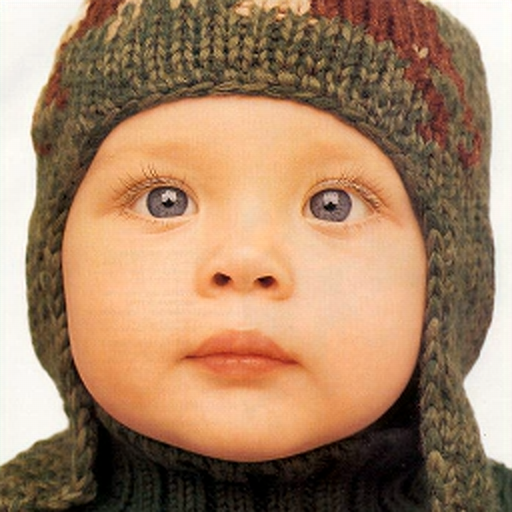

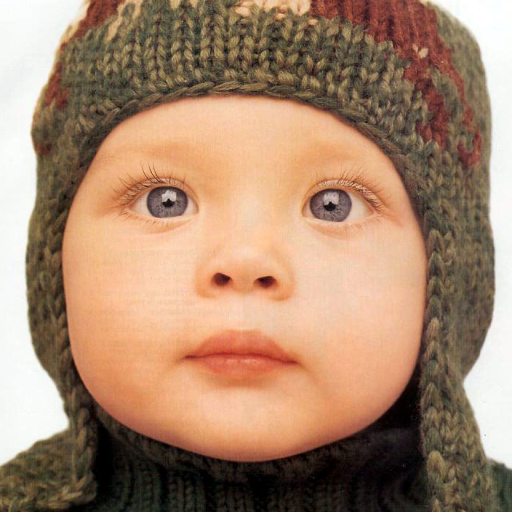

32.54565869191447


In [61]:
ps1 = psnr_calc()
print(ps1)

In [62]:
!ls

best_model_improved.h5	DIV2K_train_HR.zip  sample_data  SRCNN-Keras


In [63]:
from google.colab import files
files.download('best_model_improved.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>